# 목표 : K-Nearest Neighbor 모델 구축
# 1. 데이터 전처리 
# 2. K-Nearest Neighbor 모델 구축 
## K-fold cross validation 활용
### - k 개수 선정 " 인접한 학습데이터를 몇 개까지 탐색할 것인가?"
### - Distance measure 선정 "데이터 간 거리를 어떻게 측정할 것인가?" 
# 3. 예측 결과 평가 및 weighted KNN 구축 

# ----------------------------------------------------------

# 1. 모듈 불러오기

In [93]:
from IPython.display import display, HTML
import warnings
warnings.filterwarnings(action="ignore")

#실습용 데이터 전처리
from sklearn.datasets import load_breast_cancer

#데이터 전처리 
import numpy as np
import pandas as pd 
from sklearn.preprocessing import StandardScaler

#기계학습 모델 및 평가 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import accuracy_score, recall_score, precision_score
from tqdm import tqdm

from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import KFold
from scipy.stats import spearmanr

#시각화
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib
from matplotlib.colors import ListedColormap
matplotlib.rcParams["axes.unicode_minus"] = False # 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처

#한글폰트설정 
plt.rc("font", family="Malgun Gothic")



# 2. 데이터 불러오기 : Breast Cancer

In [94]:
from sklearn.datasets import load_breast_cancer
breast_cancer = load_breast_cancer()
print(breast_cancer.DESCR)

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        worst/largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 0 is Mean Radi

## 데이터 구조
### - 데이터: 위스콘신 대학교에서 제공한 유방암 진단결과
### - 관측치 개수: 569개
### - 변수 개수: 32개(ID:진단결과, 30개의 실측변수값)


## 설명변수(원인: 예측값을 설명할 수 있는 변수) 
### - id : 환자 식별 번호
### - radius : 반경(중심에서 외벽까지 거리들의 평균값)
### - texture : 질감(Gray-Scale 값들의 표준편차)
### - perimeter : 둘레
### - area : 면적
### - smoothness : 매끄러움(반경길이의 소극적 변화)
### - compactness : 조그만 정도(둘레^2/면적-1)
### - concavity : 오목함(윤곽의 오목한 정도)
### - points : 오목한 점의 수
### - symmetry : 대칭
### - dimension : 프렉탈 차원(해안선 근사-1)
### - mean : 3~12번 까지는 평균값을 의미
### - se : 13~22번까지는 표준오차를 의미 
### - worst : 23~32는 각 세포별 구분들에서 제일 큰 3개의 값을 평균낸 값


## 반응 변수(결과: 예측하고자 하는 값)
### - diagnosis : 양성여부(Maligant = 1 악성(유방암), Benign=0 양성(단순낭종))

In [95]:
breast_cancer.data.shape

(569, 30)

# 3. 탐색적 데이터 분석 및 데이터 전처리 
## X: 독립변수,예측변수,입력변수 
## y: 종속변수,반응변수,출력변수 


In [96]:
#데이터 프레임 형태로 변환 
X = pd.DataFrame(breast_cancer.data, columns=breast_cancer.feature_names)
y = pd.DataFrame(breast_cancer.target, columns=['diagnosis'])

In [97]:
X.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [98]:
y.tail()

,diagnosis
564,0
565,0
566,0
567,0
568,1


# 결측치(손실데이터), 데이터 타입 확인

In [99]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

In [100]:
X.describe()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


In [101]:
y["diagnosis"].value_counts()

1    357
0    212
Name: diagnosis, dtype: int64

# Train/Test 데이터 분리 
## Traning 데이터 70%/Testing 데이터 30% 나누기 

In [102]:
#Train set/ Test set 나누기  #stratify=y 가 가진 뜻은 y가 가진 1,0이 비율에 맞게 나눠지도록 하는것
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y,test_size=0.3,random_state=2021)

#데이터 칼럼 단위 정규화하기 
normalizer = StandardScaler()
X_train = normalizer.fit_transform(X_train)
X_test = normalizer.transform(X_test)

print(f'Train set dimension is {X_train.shape}')
print(f'Test set dimension is {X_test.shape}')




Train set dimension is (398, 30)
Test set dimension is (171, 30)


# 모델링 
## k 개수 결정 
## Distance measure 결정 

### k에 따른 결과 시각화로 확인해보기 
#### k가 매우 작을 경우 overfitting k가 매우 클 경우 underfitting, 적절한 k값 찾아야함

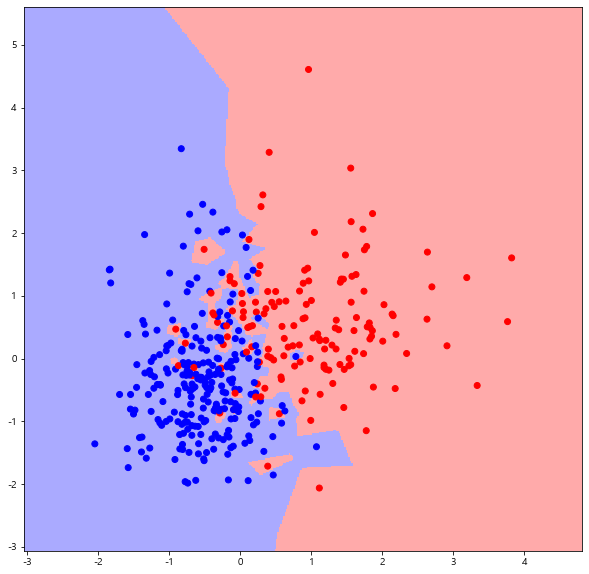

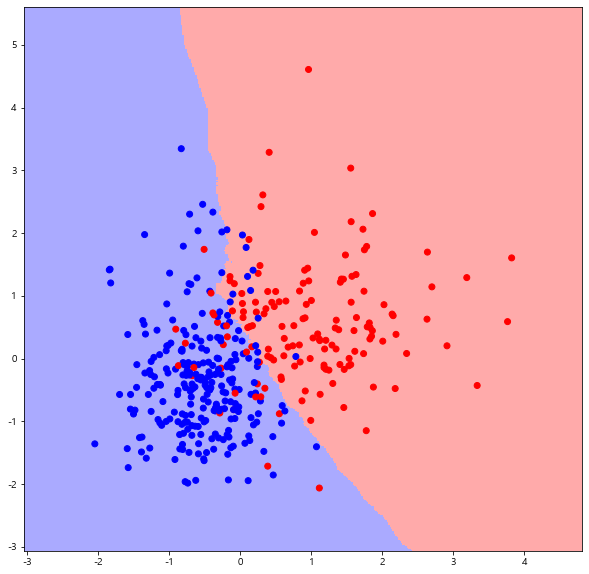

In [103]:
X_vis = X_train[:,:2]  #시각화를 위해 임의로 앞에 두개변수로 보여줌
y_vis = y_train.values.ravel()

h= .02

# 컬러맵 만들기
cmap_light = ListedColormap(["#FFAAAA", "#AAFFAA", "#AAAAFF"])
cmap_bold = ListedColormap(["#FF0000","#00FF00","#0000FF"])

for k in [1,50]:
    clf = KNeighborsClassifier(n_neighbors = k)
    clf.fit(X_vis,y_vis)
    
    x_min, x_max = X_vis[:,0].min() - 1, X_vis[:,0].max() + 1
    y_min, y_max = X_vis[:,1].min() - 1, X_vis[:,1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    
    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(10,10))
    plt.pcolormesh(xx,yy,Z,cmap = cmap_light)
    
    plt.scatter(X_vis[:,0], X_vis[:,1], c=y_vis, cmap=cmap_bold)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    


## 4.1 Hyperparameter k 결정

In [104]:
k_list = [i for i in range(1,100) if i%2 != 0] #이건 홀수만 탐색해본거 다해도됨
cv_scores = []

for k in tqdm(k_list):
    classifier = KNeighborsClassifier(n_neighbors = k,p=2) #p=1: manhatten_distance, p=2: euclidean_distance, p=1_p : minkowski_distance
    
    scores = cross_val_score(classifier, X_train, y_train, cv=10, scoring ="accuracy")
    cv_scores.append(scores.mean())
    

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 29.92it/s]


In [105]:
cv_scores

[0.9446794871794871,
 0.9548076923076924,
 0.9597435897435898,
 0.9496794871794872,
 0.9522435897435898,
 0.9496794871794872,
 0.9445512820512821,
 0.9445512820512821,
 0.9420512820512821,
 0.9420512820512821,
 0.9420512820512821,
 0.9420512820512821,
 0.9446153846153846,
 0.9471153846153847,
 0.9471153846153847,
 0.9446153846153846,
 0.9421153846153846,
 0.939551282051282,
 0.939551282051282,
 0.9420512820512821,
 0.9420512820512821,
 0.9420512820512821,
 0.9394871794871795,
 0.9369871794871795,
 0.9394871794871795,
 0.9369871794871795,
 0.9369871794871795,
 0.9369871794871795,
 0.9369871794871795,
 0.9369871794871795,
 0.9344871794871794,
 0.9319871794871796,
 0.9344871794871794,
 0.9344871794871794,
 0.9294871794871795,
 0.9244871794871795,
 0.9244871794871795,
 0.9244871794871795,
 0.9194230769230771,
 0.921923076923077,
 0.924423076923077,
 0.926923076923077,
 0.921923076923077,
 0.9194230769230771,
 0.9194230769230771,
 0.9194230769230771,
 0.9194230769230771,
 0.9194230769230771

In [106]:
best_k = [k_list[i] for i in range(len(cv_scores)) if cv_scores[i] == np.max(cv_scores)]
print("Best k value :", best_k)

Best k value : [5]


<function matplotlib.pyplot.show(close=None, block=None)>

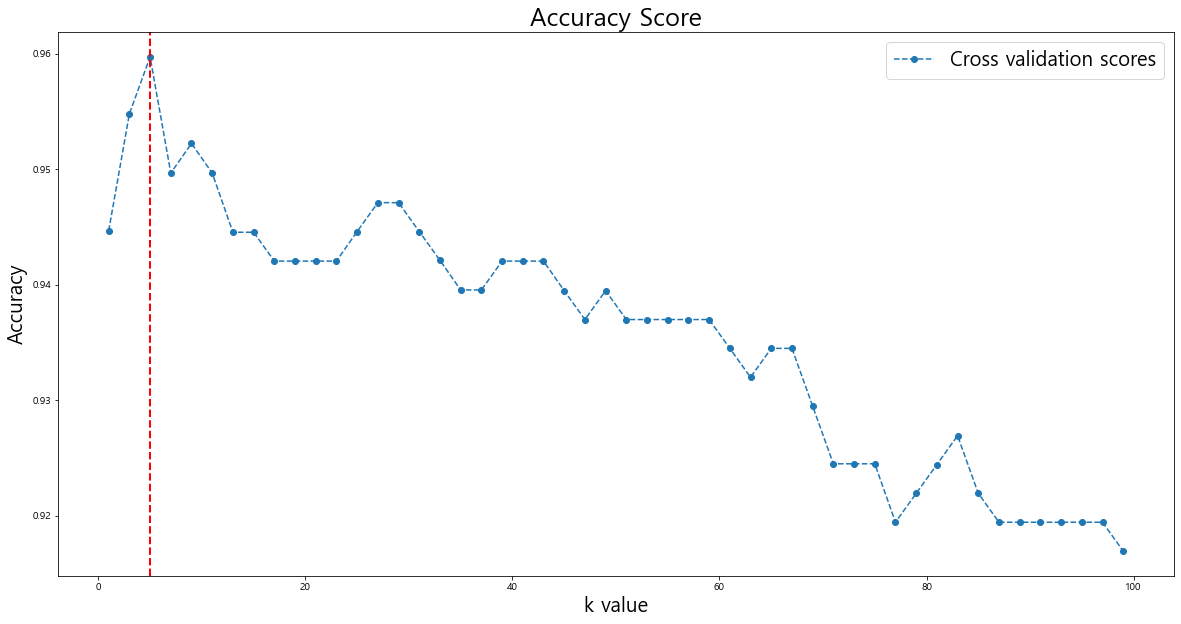

In [107]:
plt.figure(figsize=(20,10))
plt.plot(k_list, cv_scores, marker="o", linestyle="dashed")
plt.legend(["Cross validation scores"], fontsize=20)
plt.xlabel("k value", fontsize = 20)
plt.ylabel("Accuracy",fontsize = 20)
plt.title("Accuracy Score",fontsize=25)
plt.axvline(best_k[0], color="r", linestyle = "--", linewidth=2)
plt.show



# 4.2 Distance type 결정

### 4.2.1 Euclidean Distance

# Distance measures
## Euclidean distance
## - 가장 흔히 사용되는 거리측도 
## - 대응되는 x,y값 간 차이 제곱합의 제곱근으로써, 두 관측치       사이의 직선 거리를 의미


In [108]:
k_list = [i for i in range(1,100) if i%2 != 0] #이건 홀수만 탐색해본거 다해도됨

euc = []
for k in tqdm(k_list):
    classifier = KNeighborsClassifier(n_neighbors = k,p=2) #p=1: manhatten_distance, p=2: euclidean_distance, p=1_p : minkowski_distance
    scores = cross_val_score(classifier, X_train, y_train, cv=10, scoring ="accuracy")
    euc.append(scores.mean())

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 30.20it/s]


In [109]:
euc

[0.9446794871794871,
 0.9548076923076924,
 0.9597435897435898,
 0.9496794871794872,
 0.9522435897435898,
 0.9496794871794872,
 0.9445512820512821,
 0.9445512820512821,
 0.9420512820512821,
 0.9420512820512821,
 0.9420512820512821,
 0.9420512820512821,
 0.9446153846153846,
 0.9471153846153847,
 0.9471153846153847,
 0.9446153846153846,
 0.9421153846153846,
 0.939551282051282,
 0.939551282051282,
 0.9420512820512821,
 0.9420512820512821,
 0.9420512820512821,
 0.9394871794871795,
 0.9369871794871795,
 0.9394871794871795,
 0.9369871794871795,
 0.9369871794871795,
 0.9369871794871795,
 0.9369871794871795,
 0.9369871794871795,
 0.9344871794871794,
 0.9319871794871796,
 0.9344871794871794,
 0.9344871794871794,
 0.9294871794871795,
 0.9244871794871795,
 0.9244871794871795,
 0.9244871794871795,
 0.9194230769230771,
 0.921923076923077,
 0.924423076923077,
 0.926923076923077,
 0.921923076923077,
 0.9194230769230771,
 0.9194230769230771,
 0.9194230769230771,
 0.9194230769230771,
 0.9194230769230771

## 4.2.2 Manhatten Distance

### x에서 y로 이동 시 각 좌표축 방향으로만 이동할 경우에 계산되는거리

In [110]:
k_list = [i for i in range(1,100) if i%2 != 0]

nan = []
for k in tqdm(k_list):
    classifier = KNeighborsClassifier(n_neighbors = k, p=1)
    scores = cross_val_score(classifier, X_train, y_train, cv=10, scoring = "accuracy")
    nan.append(scores.mean())
    

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 30.38it/s]


In [111]:
nan

[0.9446794871794871,
 0.9597435897435898,
 0.9521794871794873,
 0.9446153846153846,
 0.9369871794871795,
 0.9444871794871796,
 0.9420512820512821,
 0.9419871794871796,
 0.9445512820512821,
 0.947051282051282,
 0.9445512820512821,
 0.9445512820512821,
 0.9445512820512821,
 0.9445512820512821,
 0.9445512820512821,
 0.9445512820512821,
 0.9419871794871796,
 0.9419871794871796,
 0.9394871794871795,
 0.9419871794871796,
 0.9419871794871796,
 0.9394871794871795,
 0.9369871794871795,
 0.9394871794871795,
 0.9394871794871795,
 0.9394871794871795,
 0.9394871794871795,
 0.9394871794871795,
 0.9394871794871795,
 0.9369871794871795,
 0.9319871794871796,
 0.9369871794871795,
 0.9319871794871796,
 0.9319871794871796,
 0.9319871794871796,
 0.9319871794871796,
 0.9269871794871796,
 0.9269871794871796,
 0.9244871794871795,
 0.921923076923077,
 0.921923076923077,
 0.921923076923077,
 0.921923076923077,
 0.921923076923077,
 0.921923076923077,
 0.921923076923077,
 0.9194230769230771,
 0.9194230769230771,


## 4.2.3 Mahalanobis Distance

### 변수 내 분산, 변수 간 공분산을 모두 반영하여 x,y 거리계산
### 데이터의 convariance matrix가 단위행렬이면 유클리드와 같음

In [112]:
y_train = y_train.values.ravel()
kf = KFold(n_splits=10)
kf.get_n_splits(X_train)

k_list = [i for i in range(1,100) if i%2 !=0]

mah = []
for k in tqdm(k_list):
    mah_acc =[]
    for train_index, valid_index in kf.split(X_train):
        X_train_f = X_train[train_index]
        y_train_f = y_train[train_index]
        
        X_valid_f = X_train[valid_index]
        y_valid_f = y_train[valid_index]
        
        total = len(y_valid_f)
        correct = 0
        
        nn = NearestNeighbors(algorithm="brute", metric="mahalanobis",
                              metric_params={"V":np.cov(X_train_f, rowvar=False)}, n_neighbors=k)
        nn_nodel = nn.fit(X_train_f, y_train_f)
        
        for v in range(len(X_valid_f)):
            distance, indices = nn_nodel.kneighbors(X_valid_f[v].reshape(1,-1))
            
            class_list = {"0":0, "1":0}
            for i in range(len(indices[0])):
                if y_train_f[indices[0][i]] == 0 :
                    class_list["0"] += 1
                else:
                    class_list["1"] += 1
                    
            max_key = np.int(max(class_list, key=class_list.get))
            if max_key == y_valid_f[v]:
                correct += 1
                
        mah_acc.append(correct/total)
    mah.append(np.mean(mah_acc))
    
        
        

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:11<00:00,  4.30it/s]


In [113]:
mah

[0.7964102564102564,
 0.786474358974359,
 0.7739102564102565,
 0.7638461538461538,
 0.7362179487179488,
 0.7337179487179487,
 0.7160897435897435,
 0.7060897435897436,
 0.6960256410256411,
 0.6810256410256411,
 0.6734615384615384,
 0.673397435897436,
 0.6632692307692308,
 0.6582692307692308,
 0.650769230769231,
 0.6482692307692309,
 0.6482692307692309,
 0.6457692307692309,
 0.6432692307692308,
 0.6382692307692308,
 0.6307692307692309,
 0.6307692307692309,
 0.6307692307692309,
 0.6307692307692309,
 0.6307692307692309,
 0.6282692307692308,
 0.6282692307692308,
 0.6282692307692308,
 0.6282692307692308,
 0.6282692307692308,
 0.6282692307692308,
 0.6282692307692308,
 0.6282692307692308,
 0.6282692307692308,
 0.6282692307692308,
 0.6282692307692308,
 0.6282692307692308,
 0.6282692307692308,
 0.6282692307692308,
 0.6282692307692308,
 0.6282692307692308,
 0.6282692307692308,
 0.6282692307692308,
 0.6282692307692308,
 0.6282692307692308,
 0.6282692307692308,
 0.6282692307692308,
 0.6282692307692

## 4.2.4 Correlation Distance - Pearson Correlation

### - 데이터간 Pearson correlation을 거리측도로 사용하는 방식
### - 데이터 패턴의 유사도를 반영할 수 있음

In [115]:
kf = KFold(n_splits=10)
kf.get_n_splits(X_train)

k_list = [i for i in range(1,100) if i%2 !=0]

pear = []
for k in tqdm(k_list):
    pear_acc =[]
    for train_index, valid_index in kf.split(X_train):
        X_train_f = X_train[train_index]
        y_train_f = y_train[train_index]
        
        X_valid_f = X_train[valid_index]
        y_valid_f = y_train[valid_index]
        
        total = len(y_valid_f)
        correct = 0
        
        nn = NearestNeighbors(metric="correlation", n_neighbors=k)
        nn_nodel = nn.fit(X_train_f, y_train_f)
        
        for v in range(len(X_valid_f)):
            distance, indices = nn_nodel.kneighbors(X_valid_f[v].reshape(1,-1))
            
            class_list = {"0":0, "1":0}
            for i in range(len(indices[0])):
                if y_train_f[indices[0][i]] == 0 :
                    class_list["0"] += 1
                else:
                    class_list["1"] += 1
                    
            max_key = np.int(max(class_list, key=class_list.get))
            if max_key == y_valid_f[v]:
                correct += 1
                
        pear_acc.append(correct/total)
    pear.append(np.mean(pear_acc))

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.50it/s]


In [116]:
pear

[0.8113461538461539,
 0.8442307692307691,
 0.8266666666666665,
 0.8342307692307692,
 0.8390384615384615,
 0.8341025641025641,
 0.8466666666666667,
 0.838974358974359,
 0.823974358974359,
 0.8315384615384614,
 0.823974358974359,
 0.8316025641025642,
 0.8366025641025641,
 0.8316666666666667,
 0.8316025641025642,
 0.826602564102564,
 0.8341025641025641,
 0.839102564102564,
 0.8264743589743591,
 0.8315384615384616,
 0.8316025641025642,
 0.8265384615384616,
 0.8291025641025641,
 0.826602564102564,
 0.8216025641025639,
 0.816602564102564,
 0.8141025641025641,
 0.8190384615384614,
 0.8191025641025641,
 0.8165384615384615,
 0.8140384615384615,
 0.8116025641025642,
 0.811602564102564,
 0.8065384615384614,
 0.8065384615384614,
 0.809102564102564,
 0.8040384615384616,
 0.809102564102564,
 0.8066025641025641,
 0.8065384615384614,
 0.801474358974359,
 0.7989102564102564,
 0.7989102564102564,
 0.7965384615384614,
 0.7990384615384615,
 0.7990384615384615,
 0.7990384615384615,
 0.8015384615384615,
 0.

## 4.2.5 Spearman rank correlation distance
### - p=Spearman correlation, 데이터의 rank를 이용하여 거리계산
### - p의 범위는 -1부터 1롸, Pearson correlation과 동일 

In [119]:
def spearmancorr(x,y):
    rho, pval = spearmanr(x,y,axis=0)
    return 1-rho

kf = KFold(n_splits=10)
kf.get_n_splits(X_train)

k_list = [i for i in range(1,100) if i%2 !=0]

spear = []
for k in tqdm(k_list):
    spear_acc =[]
    for train_index, valid_index in kf.split(X_train):
        X_train_f = X_train[train_index]
        y_train_f = y_train[train_index]
        
        X_valid_f = X_train[valid_index]
        y_valid_f = y_train[valid_index]
        
        total = len(y_valid_f)
        correct = 0
        
        nn = NearestNeighbors(metric=spearmancorr, algorithm="ball_tree")
        nn_nodel = nn.fit(X_train_f, y_train_f)
        
        for v in range(len(X_valid_f)):
            distance, indices = nn_nodel.kneighbors(X_valid_f[v].reshape(1,-1))
            
            class_list = {"0":0, "1":0}
            for i in range(len(indices[0])):
                if y_train_f[indices[0][i]] == 0 :
                    class_list["0"] += 1
                else:
                    class_list["1"] += 1
                    
            max_key = np.int(max(class_list, key=class_list.get))
            if max_key == y_valid_f[v]:
                correct += 1
                
        spear_acc.append(correct/total)
    spear.append(np.mean(spear_acc))

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [40:53<00:00, 49.06s/it]


## 비교하기 위해 시각화

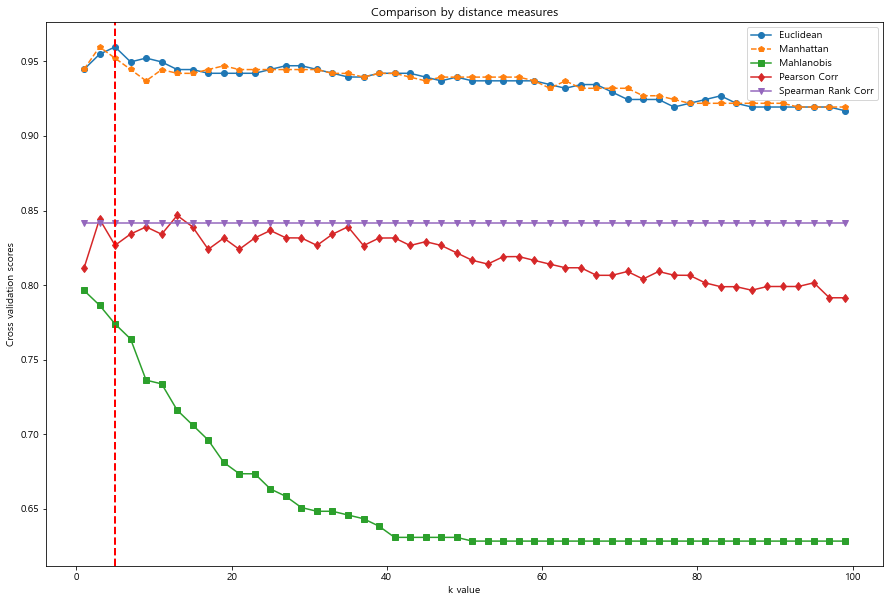

In [123]:
plt.figure(figsize=(15,10))
plt.plot(k_list, euc, marker="o")
plt.plot(k_list, nan, linestyle="dashed", marker="p")
plt.plot(k_list, mah, marker = "s")
plt.plot(k_list, pear, marker = "d")
plt.plot(k_list, spear, marker = "v")
plt.axvline(5, color="r", linestyle="--", linewidth=2)
plt.xlabel("k value")
plt.ylabel("Cross validation scores")
plt.title("Comparison by distance measures")
plt.legend(["Euclidean","Manhattan","Mahlanobis","Pearson Corr","Spearman Rank Corr"])
plt.show()

## 결국 가장 적합한 하이퍼파라미터는
## Distance measures = Euclidean distance
## K=5 

# -------------------------------------------------

## 4.2 최종 모델 선정 및 성능 확인

In [124]:
classifier = KNeighborsClassifier(n_neighbors = 5,p=2) #p=1: manhatten_distance, p=2: euclidean_distance, p=1_p : minkowski_distance
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)  ##x 테스트셋에대해 예측을 수행, 분류모델이니 정확도,민감도,정밀도

acc = accuracy_score(y_true = y_test, y_pred = y_pred) ##정확도 테스트
recall = recall_score(y_true = y_test, y_pred = y_pred) ## 민감도
precision = precision_score(y_true = y_test, y_pred = y_pred) ## 정밀도

print(f"정확도:{acc:0.2f}",f"민감도:{recall:0.2f}",f"정밀도:{precision:0.2f}",sep=" | ")


정확도:0.98 | 민감도:0.99 | 정밀도:0.97


## 4.3 Weighted KNN 적용 및 성능확인


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 45.26it/s]


Best k value : [5]


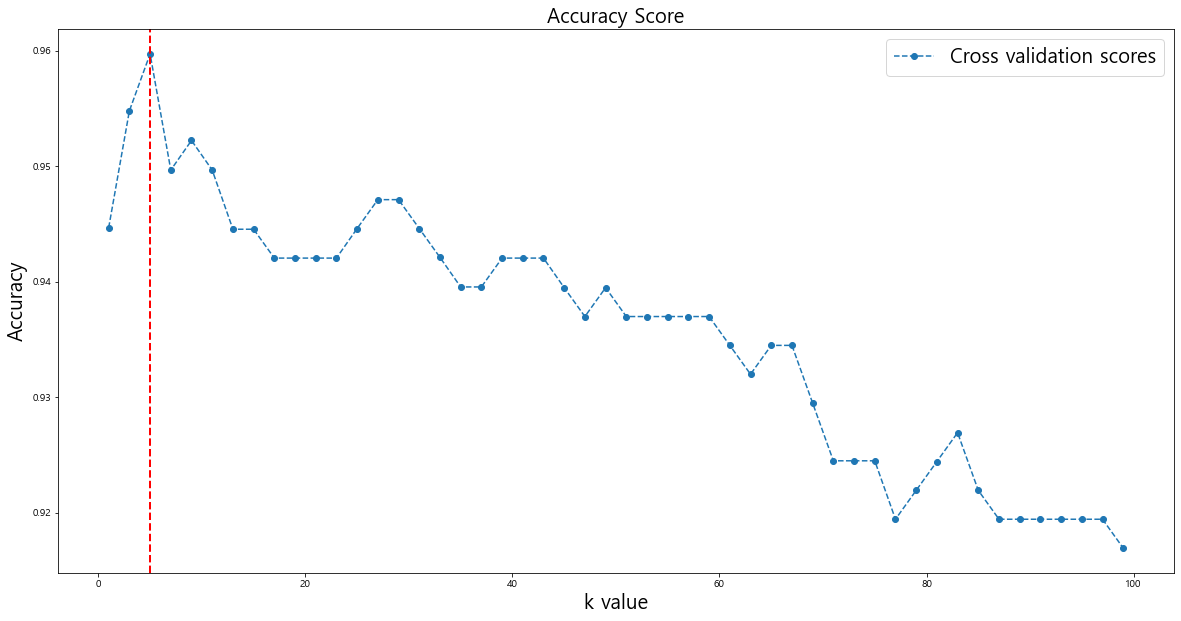

In [127]:
k_list = [i for i in range(1,100) if i%2 != 0] #이건 홀수만 탐색해본거 다해도됨

euc = []
for k in tqdm(k_list):
    classifier = KNeighborsClassifier(n_neighbors = k,p=2, weights="distance") #weight 적용안하면 uniform, weight 적용할거면 distance를 넣어라
    scores = cross_val_score(classifier, X_train, y_train, cv=10, scoring ="accuracy")
    euc.append(scores.mean())
    
best_k = [k_list[i] for i in range(len(cv_scores)) if cv_scores[i] == np.max(cv_scores)]
print("Best k value :", best_k)
    
plt.figure(figsize=(20,10))
plt.plot(k_list, cv_scores, marker="o", linestyle="dashed")
plt.legend(["Cross validation scores"], fontsize = 20)
plt.xlabel("k value", fontsize = 20 )
plt.ylabel("Accuracy", fontsize = 20)
plt.title("Accuracy Score", fontsize = 20)
plt.axvline(best_k[0], color = "r", linestyle="--", linewidth=2)
plt.show()

In [128]:
classifier = KNeighborsClassifier(n_neighbors = 5,p=2, weights="distance") #p=1: manhatten_distance, p=2: euclidean_distance, p=1_p : minkowski_distance
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)  ##x 테스트셋에대해 예측을 수행, 분류모델이니 정확도,민감도,정밀도

acc = accuracy_score(y_true = y_test, y_pred = y_pred) ##정확도 테스트
recall = recall_score(y_true = y_test, y_pred = y_pred) ## 민감도
precision = precision_score(y_true = y_test, y_pred = y_pred) ## 정밀도

print(f"정확도:{acc:0.2f}",f"민감도:{recall:0.2f}",f"정밀도:{precision:0.2f}",sep=" | ")

정확도:0.98 | 민감도:0.99 | 정밀도:0.97


## 위까지 분류모델이었음, 만약 Regression(예측모델)이면?
### *임포트와 scoring 등이 달라짐 

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:04<00:00, 11.53it/s]


Best k value : [3]


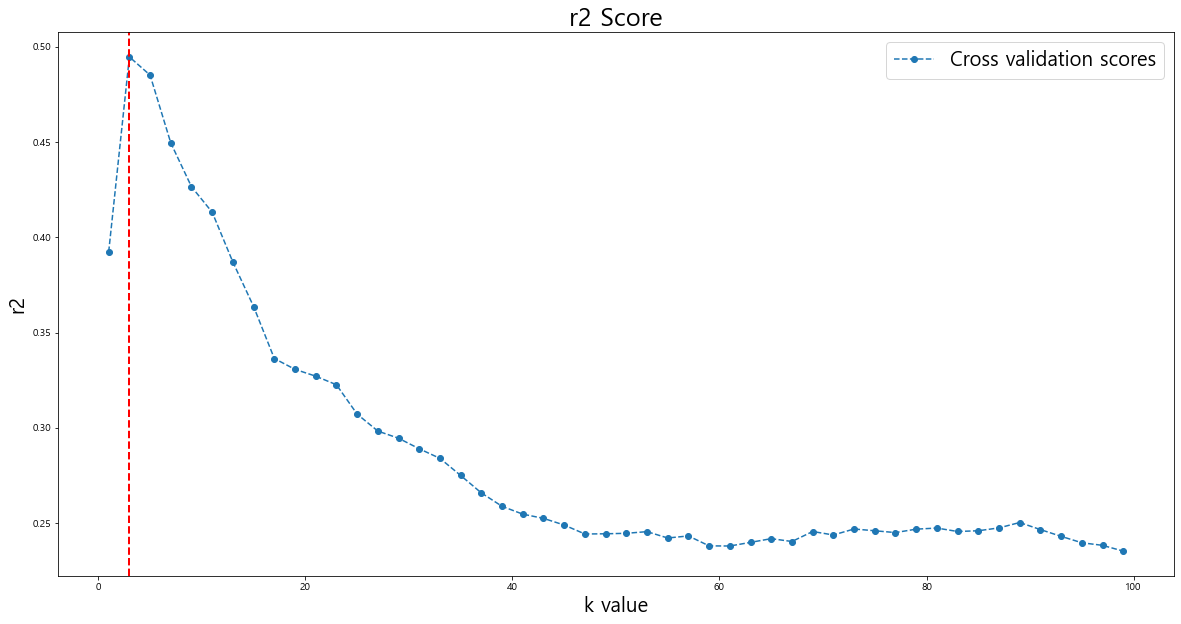

In [131]:
from sklearn.neighbors import KNeighborsRegressor 
from sklearn.datasets import load_boston 
boston = load_boston()

#데이터 프레임 형태로 변환 
X = pd.DataFrame(boston.data, columns =boston.feature_names)
y = pd.DataFrame(boston.target, columns = ["MEDV"])

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=2021)

k_list = [ i for i in range(1,100) if i%2 !=0]
cv_scores = []
for k in tqdm(k_list):
    regressor = KNeighborsRegressor(n_neighbors = k, p =2)
    
    scores = cross_val_score(regressor, X_train, y_train, cv=10, scoring="r2")
    cv_scores.append(scores.mean())
    
best_k = [k_list[i] for i in range(len(cv_scores)) if cv_scores[i] == np.max(cv_scores)]
print("Best k value :", best_k)

plt.figure(figsize=(20,10))
plt.plot(k_list, cv_scores, marker="o", linestyle="dashed")
plt.legend(["Cross validation scores"], fontsize = 20)
plt.xlabel("k value", fontsize = 20 )
plt.ylabel("r2", fontsize = 20)
plt.title("r2 Score", fontsize = 25)
plt.axvline(best_k[0], color = "r", linestyle="--", linewidth=2)
plt.show()
